In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import umap  # pip install umap-learn

df = pd.read_csv('results/State-Vis-Pretraining/ALE/Pong-v5/Trajectory_visualisations/data.csv')
# Split into X and y
X = df.drop(columns=['Episode', 'Step','y'])  # All columns except 'y'

label_encoder = LabelEncoder()
# Convert string labels to integers
y = label_encoder.fit_transform(df['y'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'HUMAN_001': 0, 'SAC_PEBBLE': 1}


In [2]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,28214,28215,28216,28217,28218,28219,28220,28221,28222,28223
0,52,52,52,52,80,87,87,87,87,87,...,236,236,236,236,236,236,236,236,236,236
1,52,52,52,52,80,87,87,87,87,87,...,236,236,236,236,236,236,236,236,236,236
2,52,52,52,52,80,87,87,87,87,87,...,236,236,236,236,236,236,236,236,236,236
3,52,52,52,52,80,87,87,87,87,87,...,236,236,236,236,236,236,236,236,236,236
4,52,52,52,52,80,87,87,87,87,87,...,236,236,236,236,236,236,236,236,236,236


In [4]:
# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

/Users/andreas/miniconda3/envs/xdrl/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (758). n_quantiles is set to n_samples.
  warnings.warn(


In [5]:
# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
# Fit t-SNE to processed data
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)

In [7]:
X_tsne.shape

(758, 2)

In [8]:
df_umap = pd.DataFrame(X_reduced_2, columns=['UMAP_x', 'UMAP_y'])
df_umap['TSNE_x'] = X_tsne[:,0]
df_umap['TSNE_y'] = X_tsne[:,1]
df_umap['Episode'] = df['Episode']
df_umap['Step'] = df['Step']
df_umap['y'] = df['y']
df_umap


,UMAP_x,UMAP_y,TSNE_x,TSNE_y,Episode,Step,y
0,-12.659808,3.699445,-7.648170,-16.930038,1_0,0,SAC_PEBBLE
1,-12.626365,3.732600,-14.345246,-26.856564,1_0,1,SAC_PEBBLE
2,-6.559625,-1.187086,-20.144711,-9.225402,1_0,2,SAC_PEBBLE
3,7.961234,15.475394,-59.420906,9.878386,1_0,3,SAC_PEBBLE
4,1.447228,0.138308,-29.544579,-37.310074,1_0,4,SAC_PEBBLE
...,...,...,...,...,...,...,...
753,10.399503,-5.009851,51.499535,-37.350525,0_2,121,HUMAN_001
754,9.756800,-4.807611,21.636103,-46.544880,0_2,122,HUMAN_001
755,9.724438,-4.783868,18.895746,-43.876926,0_2,123,HUMAN_001
756,9.717351,-4.757491,16.017714,-43.398251,0_2,124,HUMAN_001


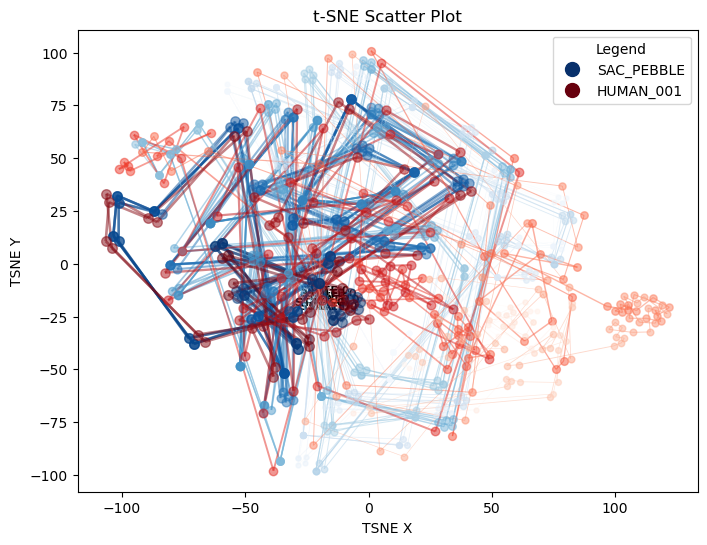

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection

dim2D_x = 'TSNE_x'
dim2D_y = 'TSNE_y'

unique_y_values = df_umap['y'].unique()
# Define colors for each unique value of 'y'
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_y_values)))
# cmap = cm.Blues  
cmap = [cm.Blues.reversed(), cm.Reds.reversed()]  # You can choose other colormaps like 'Greens', 'Purples', etc.

# Plot the results
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(df_umap['UMAP_x'], df_umap['UMAP_y'], c=df_umap['y'], s=0.5, cmap='viridis', label='Data points')

# Prepare a list to store legend handles
legend_handles = []

for i, y_value in enumerate(unique_y_values):
    subset = df_umap[df_umap['y'] == y_value]

    # Create a colormap for each y_value based on Step
    
    norm = plt.Normalize(subset['Step'].min(), subset['Step'].max())  # Normalize Step for this y_value
    
    # Extract the color for the legend from the first Step (or minimum Step)
    first_color = cmap[i](norm(subset['Step'].min()))
    
    # Create a legend handle with the y value and its color
    legend_handles.append(mlines.Line2D([], [], color=first_color, marker='o', linestyle='None', markersize=10, label=str(y_value)))
    
    # Plot scatter points with the same colormap for each y_value
    for _, row in subset.iterrows():
        color = cmap[i](norm(row['Step']))  # Color based on the current Step value
        marker_size = 50 - 40 * (row['Step'] / subset['Step'].max())  # Marker size, thick to thin
        plt.scatter(row[dim2D_x], row[dim2D_y], color=color, s=marker_size, alpha=0.5, zorder = 20)

    # For each 'Episode', plot the lines connecting points from Step 0 to the last Step
    for episode in subset['Episode'].unique():
        episode_data = subset[subset['Episode'] == episode].sort_values('Step')
        
        # Get the coordinates of the first step (Step 0) to annotate "STATE ZERO"
        first_step = episode_data[episode_data['Step'] == 0]
        if not first_step.empty:
            first_step_x = first_step[dim2D_x].values[0]
            first_step_y = first_step[dim2D_y].values[0]
            plt.text(first_step_x, first_step_y, 'STATE 0', fontsize=8, ha='right', color='black', fontweight='bold')

        # Create line segments between each consecutive point
        segments = []
        colors = []
        linewidths = []

        # Interpolate the color for each segment (shades of blue)
        for j in range(len(episode_data) -1):
            x_vals = episode_data.iloc[j:j+2][dim2D_x].values
            y_vals = episode_data.iloc[j:j+2][dim2D_y].values
            step_vals = episode_data.iloc[j:j+2]['Step'].values

            # Add the segment to segments list
            segments.append([(x_vals[0], y_vals[0]), (x_vals[1], y_vals[1])])

            # Line color based on the current step in the segment (single color gradient)
            color = cmap[i](norm(step_vals[0]))  # Color based on the current step
            # Line thickness: thicker at the beginning (Step 0) and thinner at the end
            linewidth = 2 - 1.9 * (step_vals[0] / episode_data['Step'].max())  # Gradually decreasing thickness
            colors.append(color)
            linewidths.append(linewidth)

        # Create a LineCollection for the segments in this episode
        lc = LineCollection(segments, colors=colors, linewidths=linewidths, alpha=0.5, zorder = 10)
        plt.gca().add_collection(lc)

            # plt.plot(x_vals, y_vals, color=color, linewidth=linewidth, alpha=0.5, zorder = 10)  # Alpha for transparency

# Add title and labels
plt.title('t-SNE Scatter Plot')
plt.xlabel('TSNE X')
plt.ylabel('TSNE Y')
# Add custom legend
plt.legend(handles=legend_handles, title="Legend", loc='best')

plt.show()

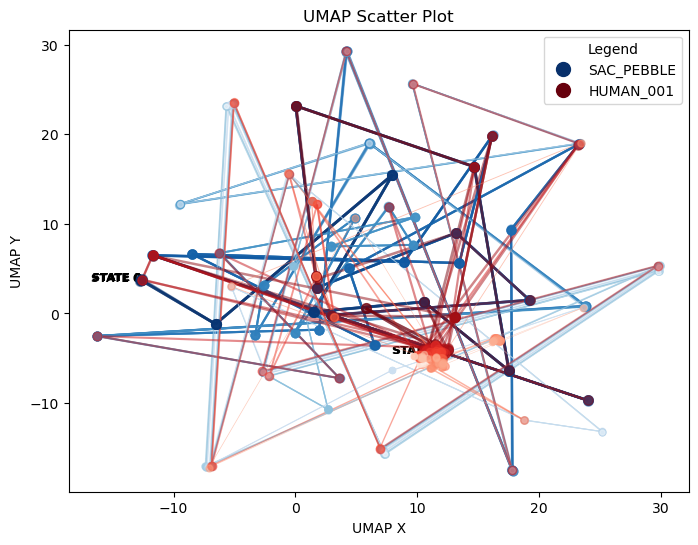

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection

dim2D_x = 'UMAP_x'
dim2D_y = 'UMAP_y'

unique_y_values = df_umap['y'].unique()
# Define colors for each unique value of 'y'
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_y_values)))
# cmap = cm.Blues  
cmap = [cm.Blues.reversed(), cm.Reds.reversed()]  # You can choose other colormaps like 'Greens', 'Purples', etc.

# Plot the results
plt.figure(figsize=(8, 6))
# scatter = plt.scatter(df_umap['UMAP_x'], df_umap['UMAP_y'], c=df_umap['y'], s=0.5, cmap='viridis', label='Data points')

# Prepare a list to store legend handles
legend_handles = []

for i, y_value in enumerate(unique_y_values):
    subset = df_umap[df_umap['y'] == y_value]

    # Create a colormap for each y_value based on Step
    
    norm = plt.Normalize(subset['Step'].min(), subset['Step'].max())  # Normalize Step for this y_value
    
    # Extract the color for the legend from the first Step (or minimum Step)
    first_color = cmap[i](norm(subset['Step'].min()))
    
    # Create a legend handle with the y value and its color
    legend_handles.append(mlines.Line2D([], [], color=first_color, marker='o', linestyle='None', markersize=10, label=str(y_value)))
    
    # Plot scatter points with the same colormap for each y_value
    for _, row in subset.iterrows():
        color = cmap[i](norm(row['Step']))  # Color based on the current Step value
        marker_size = 50 - 40 * (row['Step'] / subset['Step'].max())  # Marker size, thick to thin
        plt.scatter(row[dim2D_x], row[dim2D_y], color=color, s=marker_size, alpha=0.5, zorder = 20)

    # For each 'Episode', plot the lines connecting points from Step 0 to the last Step
    for episode in subset['Episode'].unique():
        episode_data = subset[subset['Episode'] == episode].sort_values('Step')
        
        # Get the coordinates of the first step (Step 0) to annotate "STATE ZERO"
        first_step = episode_data[episode_data['Step'] == 0]
        if not first_step.empty:
            first_step_x = first_step[dim2D_x].values[0]
            first_step_y = first_step[dim2D_y].values[0]
            plt.text(first_step_x, first_step_y, 'STATE 0', fontsize=8, ha='right', color='black', fontweight='bold')

        # Create line segments between each consecutive point
        segments = []
        colors = []
        linewidths = []

        # Interpolate the color for each segment (shades of blue)
        for j in range(len(episode_data) -1):
            x_vals = episode_data.iloc[j:j+2][dim2D_x].values
            y_vals = episode_data.iloc[j:j+2][dim2D_y].values
            step_vals = episode_data.iloc[j:j+2]['Step'].values

            # Add the segment to segments list
            segments.append([(x_vals[0], y_vals[0]), (x_vals[1], y_vals[1])])

            # Line color based on the current step in the segment (single color gradient)
            color = cmap[i](norm(step_vals[0]))  # Color based on the current step
            # Line thickness: thicker at the beginning (Step 0) and thinner at the end
            linewidth = 2 - 1.9 * (step_vals[0] / episode_data['Step'].max())  # Gradually decreasing thickness
            colors.append(color)
            linewidths.append(linewidth)

        # Create a LineCollection for the segments in this episode
        lc = LineCollection(segments, colors=colors, linewidths=linewidths, alpha=0.5, zorder = 10)
        plt.gca().add_collection(lc)

            # plt.plot(x_vals, y_vals, color=color, linewidth=linewidth, alpha=0.5, zorder = 10)  # Alpha for transparency

# Add title and labels
plt.title('UMAP Scatter Plot')
plt.xlabel('UMAP X')
plt.ylabel('UMAP Y')
# Add custom legend
plt.legend(handles=legend_handles, title="Legend", loc='best')

plt.show()